# Joint Analysis of HiPSCats

Here we will demonstrate the LSDB capabilities of analyzing multiple catalogs. LSDB comes equipped with its own nearest-neighbor crossmatching routine. 

### In this notebook we will...
* build off the querying functionality we established before
* analyze multiple hipscat catalogs through cross-matching
* plot a scientific result from our analysis

In [1]:
ENV = "local"
BUCKET = "epyc"

report_filename_1 = f"results/{ENV}_{BUCKET}/compute_1.html"
report_filename_2 = f"results/{ENV}_{BUCKET}/compute_2.html"

### First we start with opening two catalogs from a cloud almanac

In [2]:
from hipscat.inspection.almanac import Almanac

ALMANAC_DIR = "https://epyc.astro.washington.edu/~lincc-frameworks/almanac"

almanac = Almanac(dirs=[ALMANAC_DIR])
for catalog in almanac.catalogs():
    print(catalog)

gaia
gaia_10arcs
gaia_source_id_index
ztf_dr14
zubercal


### Let's analyze ztf and gaia, first lets see what columns we want from ztf

In [3]:
from lsdb import read_hipscat

ztf_info = almanac.get_almanac_info("ztf_dr14")
ztf = read_hipscat(ztf_info.catalog_path)

In [4]:
ztf

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
npartitions=2352,,,,,,,,,,,,,,,
0,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32
18014398509481984,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13830554455654793216,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
#look at ztf to choose which columns we want
ztf.dtypes

ps1_objid            int64
ra                 float64
dec                float64
ps1_gMeanPSFMag    float64
ps1_rMeanPSFMag    float64
ps1_iMeanPSFMag    float64
nobs_g               int32
nobs_r               int32
nobs_i               int32
mean_mag_g         float64
mean_mag_r         float64
mean_mag_i         float64
Norder               int32
Dir                  int32
Npix                 int32
dtype: object

Let's choose mean object magnitude for each filter, plus the number of observations for each filter. 

In [6]:
ztf_info = almanac.get_almanac_info("ztf_dr14")
gaia_info = almanac.get_almanac_info("gaia")

In [7]:
ztf = read_hipscat(ztf_info.catalog_path, columns=['ra', 'dec', 'ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g', 'mean_mag_r', 'mean_mag_i'])
ztf

,ra,dec,ps1_objid,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i
npartitions=2352,,,,,,,,,
0,float64,float64,int64,int32,int32,int32,float64,float64,float64
18014398509481984,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
13830554455654793216,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...


In [8]:
gaia = read_hipscat(gaia_info.catalog_path, columns=['ra', 'dec', 'pmra', 'pmdec'])
gaia

,ra,dec,pmra,pmdec
npartitions=3933,,,,
0,float64,float64,float64,float64
72057594037927936,...,...,...,...
...,...,...,...,...
13817043656772681728,...,...,...,...
18446744073709551615,...,...,...,...


In [9]:
from dask.distributed import Client, performance_report
from IPython.display import display, HTML

client = Client(n_workers=3, threads_per_worker=1, memory_limit="2GB")

## Cross-matching

Let's cull our gaia catalog by performing a conesearch, then cross-match it with ztf.

What our cross_match routine does is performs a nearest-neighbor (1) with a distance threshold of 0.1 degrees

In [10]:
xmatch = gaia.cone_search(
    ra=30,
    dec=30,
    radius_arcsec=5*3600,
).crossmatch(
    ztf,
    n_neighbors=1,
    radius_arcsec=0.1*3600,
    require_right_margin=False,
)
xmatch

/Users/scampos/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_dist_arcsec
npartitions=21,,,,,,,,,,,,,,
144115188075855872,float64,float64,float64,float64,float64,float64,int64,int32,int32,int32,float64,float64,float64,float64
162129586585337856,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662029145223462912,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [11]:
type(xmatch)

lsdb.catalog.catalog.Catalog

In [12]:
with performance_report(filename=report_filename_1):
    xmatch.compute()

display(HTML(report_filename_1))

2024-04-15 13:26:41,633 - distributed.sizeof - WARNING - Sizeof calculation failed. Defaulting to -1 B
Traceback (most recent call last):
  File "/Users/scampos/anaconda3/envs/lsdb-env/lib/python3.10/site-packages/distributed/sizeof.py", line 17, in safe_sizeof
    return sizeof(obj)
  File "/Users/scampos/anaconda3/envs/lsdb-env/lib/python3.10/site-packages/dask/utils.py", line 773, in __call__
    return meth(arg, *args, **kwargs)
  File "/Users/scampos/anaconda3/envs/lsdb-env/lib/python3.10/site-packages/dask/sizeof.py", line 96, in sizeof_python_dict
    + sizeof(list(d.values()))
  File "/Users/scampos/anaconda3/envs/lsdb-env/lib/python3.10/site-packages/dask/utils.py", line 773, in __call__
    return meth(arg, *args, **kwargs)
  File "/Users/scampos/anaconda3/envs/lsdb-env/lib/python3.10/site-packages/dask/sizeof.py", line 59, in sizeof_python_collection
    return sys.getsizeof(seq) + sum(map(sizeof, seq))
  File "/Users/scampos/anaconda3/envs/lsdb-env/lib/python3.10/site-packa

### Performing a computation based off the xmatch result

Let's create a column based on the columns we selected from each catalog, and then reduce our result based on that column. Say, I want high-proper motion stars with `n_obs` greater than 50 in each ZTF photometric band. 
* I will assign a `pm` column 
* then query based off the `pm` column, and the `nobs_filter_ztf_dr14` columns
* finally create some color columns to create a plot

In [13]:
import numpy as np

with performance_report(filename=report_filename_2):
    high_pm_ztf_sample = gaia.cone_search(
        ra=31,
        dec=30,
        radius_arcsec=1*3600,
    ).crossmatch(
        ztf,
        n_neighbors=1,
        radius_arcsec=0.1*3600,
        require_right_margin=False,
    ).assign(
        pm=lambda x: np.sqrt(x['pmra_gaia']**2 + x['pmdec_gaia']**2),
        g_minus_r=lambda x: x["mean_mag_g_ztf_dr14"]-x["mean_mag_r_ztf_dr14"],
        r_minus_i=lambda x: x["mean_mag_r_ztf_dr14"]-x["mean_mag_i_ztf_dr14"]
    ).query(
        "pm > 20 and nobs_g_ztf_dr14 > 20 and nobs_r_ztf_dr14 > 20 and nobs_i_ztf_dr14 > 20"
    ).compute()

display(HTML(report_filename_2))

/Users/scampos/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


In [14]:
high_pm_ztf_sample

,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_dist_arcsec,pm,g_minus_r,r_minus_i
_hipscat_index,,,,,,,,,,,,,,,,,
599523986048548864,31.452369,29.117978,152.121865,48.148373,31.452506,29.118031,142940314521452107,468,621,46,18.704597,17.171548,15.687665,0.470904,159.559793,1.533049,1.483882
599535366034161664,31.510317,29.135635,1.972488,-26.800893,31.510311,29.135627,142960315103013396,562,707,46,16.495046,15.064368,13.947709,0.034618,26.873381,1.430679,1.116659
599535681508737024,31.488615,29.131956,17.115564,-11.767646,31.488633,29.131964,142950314885798983,121,470,41,21.315982,19.949836,19.124021,0.064205,20.770653,1.366146,0.825814
599537121631404032,31.571129,29.207815,31.935100,2.275502,31.571149,29.207835,143040315710599966,405,674,44,20.287657,18.819879,17.827656,0.096306,32.016067,1.467779,0.992223
599537818871529472,31.658573,29.192098,14.768111,-40.653208,31.658577,29.192080,143030316585221168,562,707,46,15.782570,14.847666,14.532339,0.066602,43.252519,0.934903,0.315327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602648558314717184,31.556337,30.868702,-14.146649,-85.006615,31.556317,30.868642,145040315563473159,497,727,44,16.732946,15.306020,14.505238,0.221891,86.175706,1.426926,0.800781
602649271119904768,31.543404,30.860114,84.733184,-41.809729,31.543488,30.860094,145030315432672793,468,723,46,19.199546,17.622687,16.018039,0.266947,94.486856,1.576859,1.604648
602919888754835456,30.259647,30.741071,19.424923,-11.372447,30.259699,30.741081,144880302596389863,112,527,51,21.388939,20.041064,18.818057,0.165501,22.509113,1.347875,1.223007


### Let's plot our result color-color diagram
And see if there is any correlation with our calculated proper motions

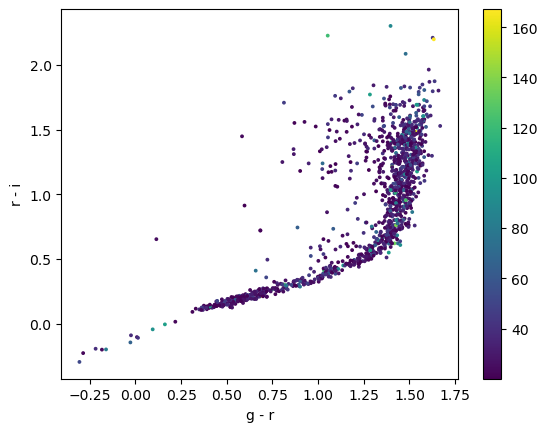

In [15]:
import matplotlib.pyplot as plt

ax = plt.subplot()
im = ax.scatter(
    high_pm_ztf_sample["g_minus_r"],
    high_pm_ztf_sample["r_minus_i"],
    c=high_pm_ztf_sample["pm"],
    s=3,
)
ax.set_xlabel("g - r")
ax.set_ylabel("r - i")
plt.colorbar(im)
plt.show()

In [16]:
client.shutdown()